In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
HOME = "/content/drive/MyDrive/Test"
print(HOME)

/content/drive/MyDrive/Test


**IMPORTS**

In [ ]:
!pip install tensorflow tensorflow-hub opencv-python matplotlib

In [ ]:
%cd {HOME}/yolov5
!pip install -r requirements.txt

import torch
import utils

display = utils.notebook_init()

YOLOv5 🚀 v7.0-187-g0004c74 Python-3.10.12 torch-2.0.1+cu118 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.2/107.7 GB disk)


In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any, Generator
import cv2
import numpy as np
import math
import tensorflow as tf
import tensorflow_hub as hub

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torch
from google.colab.patches import cv2_imshow
import math
from PIL import Image


In [ ]:
WEIGHTS_PATH = f"/content/drive/MyDrive/Test/best.pt"

In [ ]:
def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()

In [ ]:
SOURCE_VIDEO_PATH = f"/content/drive/MyDrive/Test/clips/v2.mp4"

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', WEIGHTS_PATH)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-187-g0004c74 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
Adding AutoShape... 


In [ ]:
%cd {HOME}
# !git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox

/content/drive/MyDrive/Test
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 64.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement onnxruntime==1.8.0 (from versions: 1.12.0, 1.12.1, 1.13.1, 1.14.0, 1.14.1, 1.15.0, 1.15.1)
ERROR: No matching distribution found for onnxruntime==1.8.0
No CUDA runtime 

In [ ]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

In [ ]:
!pip install onemetric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 3.5 MB/s eta 0:00:00


In [ ]:

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install loguru
!pip install lap

from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

  Using cached loguru-0.7.0-py3-none-any.whl (59 kB)
  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1655213 sha256=5f28b41266347ada50a4721ffbe67a14f89fe423677d309887d218cf46b4e98f
  Stored in directory: /root/.cache/pip/wheels/00/42/2e/9dfe19270eea279d79e84767ff0d7b8082c3bf776cad00e83d
Successfully built lap


In [ ]:

# geometry utilities


@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x

    @property
    def min_y(self) -> float:
        return self.y

    @property
    def max_x(self) -> float:
        return self.x + self.width

    @property
    def max_y(self) -> float:
        return self.y + self.height

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding,
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )

    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities


@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None
    team_id: Optional[int] = None

    def remove_box(self):
      self.rect = None
    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result


def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection
        in detections
        if detection.class_name == class_name
    ]


# draw utilities


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
    return image


def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.ellipse(
        image,
        center=rect.bottom_center.int_xy_tuple,
        axes=(int(rect.width), int(0.35 * rect.width)),
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


# base annotator


@dataclass
class BaseAnnotator:
    colors: List[Color]
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection], selected_tracker_id: Optional[int] = None) -> np.ndarray:
        annotated_image = image.copy()

        for detection in detections:

          if detection.tracker_id == selected_tracker_id or selected_tracker_id is None:

              annotated_image = draw_ellipse(
                  image=image,
                  rect=detection.rect,
                  color=self.colors[detection.class_id],
                  thickness=self.thickness
              )
          # else:

          #     detection.remove_box()


        return annotated_image

In [ ]:
# white
BALL_COLOR_HEX = "#FFFFFF"
BALL_COLOR = Color.from_hex_string(BALL_COLOR_HEX)

# red
GOALKEEPER_COLOR_HEX = "#850101"
GOALKEEPER_COLOR = Color.from_hex_string(GOALKEEPER_COLOR_HEX)

# green
PLAYER_COLOR_HEX = "#00D4BB"
PLAYER_COLOR = Color.from_hex_string(PLAYER_COLOR_HEX)

# yellow
REFEREE_COLOR_HEX = "#FFFF00"
REFEREE_COLOR = Color.from_hex_string(REFEREE_COLOR_HEX)

COLORS = [
    BALL_COLOR,
    GOALKEEPER_COLOR,
    PLAYER_COLOR,
    REFEREE_COLOR
]
THICKNESS = 4

In [ ]:
# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

In [ ]:
# initiate annotators
annotator = BaseAnnotator(
    colors=COLORS,
    thickness=THICKNESS)

In [ ]:
# black
MARKER_CONTOUR_COLOR_HEX = "000000"
MARKER_CONTOUR_COLOR = Color.from_hex_string(MARKER_CONTOUR_COLOR_HEX)

# red
PLAYER_MARKER_FILL_COLOR_HEX = "FF0000"
PLAYER_MARKER_FILL_COLOR = Color.from_hex_string(PLAYER_MARKER_FILL_COLOR_HEX)

# green
BALL_MERKER_FILL_COLOR_HEX = "00FF00"
BALL_MARKER_FILL_COLOR = Color.from_hex_string(BALL_MERKER_FILL_COLOR_HEX)

MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
MARKER_MARGIN = 10

# distance in pixels from the player's bounding box where we consider the ball is in his possession
PLAYER_IN_POSSESSION_PROXIMITY = 30

In [ ]:


# calculates coordinates of possession marker
def calculate_marker(anchor: Point) -> np.ndarray:
    x, y = anchor.int_xy_tuple
    return(np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ]))


# draw single possession marker
def draw_marker(image: np.ndarray, anchor: Point, color: Color) -> np.ndarray:
    possession_marker_countour = calculate_marker(anchor=anchor)
    image = draw_filled_polygon(
        image=image,
        countour=possession_marker_countour,
        color=color)
    image = draw_polygon(
        image=image,
        countour=possession_marker_countour,
        color=MARKER_CONTOUR_COLOR,
        thickness=MARKER_CONTOUR_THICKNESS)
    return image


# dedicated annotator to draw possession markers on video frames
@dataclass
class MarkerAnntator:

    color: Color

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_marker(
              image=image,
              anchor=detection.rect.top_center,
              color=self.color)
        return annotated_image

In [ ]:

# resolves which player is currently in ball possession based on player-ball proximity
def get_player_in_possession(
    player_detections: List[Detection],
    ball_detections: List[Detection],
    proximity: int
) -> Optional[Detection]:
    if len(ball_detections) != 1:
        return None
    ball_detection = ball_detections[0]
    for player_detection in player_detections:
        if player_detection.rect.pad(proximity).contains_point(point=ball_detection.rect.center):
            return player_detection

In [ ]:
# initiate annotators
ball_marker_annotator = MarkerAnntator(color=BALL_MARKER_FILL_COLOR)
player_marker_annotator = MarkerAnntator(color=PLAYER_MARKER_FILL_COLOR)


In [ ]:


"""
usage example:

video_config = VideoConfig(
    fps=30,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH,
    video_config=video_config)

for frame in frames:
    ...
    video_writer.write(frame)

video_writer.release()
"""


# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int


# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path,
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps=video_config.fps,
        frameSize=(video_config.width, video_config.height),
        isColor=True
    )

In [ ]:

"""
BYTETracker does not assign tracker_id to existing bounding boxes but rather
predicts the next bounding box position based on previous one. Therefore, we
need to find a way to match our bounding boxes with predictions.

usage example:

byte_tracker = BYTETracker(BYTETrackerArgs())
for frame in frames:
    ...
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(),
        names=model.names)
    ...
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape)
    detections = match_detections_with_tracks(detections=detections, tracks=tracks)
"""

# converts List[Detection] into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: List[Detection],
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

In [ ]:
# text annotator to display tracker_id
@dataclass
class TextAnnotator:
    background_color: Color
    text_color: Color
    text_thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            # if tracker_id is not assigned skip annotation
            if detection.tracker_id is None:
                continue
            if detection.rect is None:
                continue
            # calculate text dimensions
            size, _ = cv2.getTextSize(
                str(detection.tracker_id),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                thickness=self.text_thickness)
            width, height = size

            # calculate text background position
            center_x, center_y = detection.rect.bottom_center.int_xy_tuple
            x = center_x - width // 2
            y = center_y - height // 2 + 10

            # draw background
            annotated_image = draw_filled_rect(
                image=annotated_image,
                rect=Rect(x=x, y=y, width=width, height=height).pad(padding=5),
                color=self.background_color)

            # draw text
            annotated_image = draw_text(
                image=annotated_image,
                anchor=Point(x=x, y=y + height),
                text=str(detection.tracker_id),
                color=self.text_color,
                thickness=self.text_thickness)
        return annotated_image

In [ ]:
def check_color_presence(image, color):
    # Convert the user input color to lowercase
    color = color.lower()
    if color == "white":
      thresh = 2
    else:
      thresh = 1
    # Define the color range dictionary
    color_ranges = {
        "red": (np.array([0, 0, 100]), np.array([50, 50, 255])),
        "orange": (np.array([0, 100, 200]), np.array([30, 150, 255])),
        "yellow": (np.array([0, 200, 200]), np.array([50, 255, 255])),
        "green": (np.array([0, 100, 0]), np.array([50, 255, 50])),
        "blue": (np.array([100, 0, 0]), np.array([255, 50, 50])),
        "purple": (np.array([100, 0, 100]), np.array([255, 50, 255])),
        "pink": (np.array([150, 100, 200]), np.array([255, 150, 255])),
        "white": (np.array([200, 200, 200]), np.array([255, 255, 255])),
        "black": (np.array([0, 0, 0]), np.array([50, 50, 50])),
    }

    # Check if the color is supported
    if color in color_ranges:
        lower_range, upper_range = color_ranges[color]

        # Create a mask using the color range
        mask = cv2.inRange(image, lower_range, upper_range)

        # Count the number of white pixels in the mask
        white_pixel_count = cv2.countNonZero(mask)

        # Calculate the total number of pixels in the image
        total_pixels = image.shape[0] * image.shape[1]

        # Calculate the percentage of white pixels
        percentage = (white_pixel_count / total_pixels) * 100

        # Check if the percentage is greater than 70%
        if percentage > thresh:
            return True
        else:
            return False
    else:
        return False


In [ ]:


def distance_between_detections(detection1, detection2):
    x1, y1 = detection1.rect.x, detection1.rect.y
    x2, y2 = detection2.rect.x, detection2.rect.y
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

In [ ]:
model2 = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model2.signatures['serving_default']

In [ ]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))

    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}


def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))

    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]

        if (c1 > confidence_threshold) & (c2 > confidence_threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 4)

In [ ]:
# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [ ]:
TARGET_VIDEO_PATH = f"{HOME}/final/v2_out.mp4"

In [ ]:
def process(file_path):
  # initiate video writer
  video_config = VideoConfig(
      fps=60,
      width=1920,
      height=1080)
  video_writer = get_video_writer(
      target_video_path=TARGET_VIDEO_PATH,
      video_config=video_config)

  # get fresh video frame generator
  frame_iterator = iter(generate_frames(video_file=file_path))

  # initiate annotators
  base_annotator = BaseAnnotator(
      colors=[
          BALL_COLOR,
          PLAYER_COLOR,
          PLAYER_COLOR,
          REFEREE_COLOR
      ],
      thickness=THICKNESS)

  pass_proximity_threshold = 60  # Distance threshold for considering a pass
  pass_time_window = 10  # Number of frames within which a pass should occur

  # Initialize variables for pass detection
  pass_detected = False
  pass_start_frame = 0
  pass_start_player = None
  pass_end_frame = 0
  pass_end_player = None
  valid_passes =[]

  player_goalkeeper_text_annotator = TextAnnotator(
      PLAYER_COLOR, text_color=Color(255, 255, 255), text_thickness=2)

  referee_text_annotator = TextAnnotator(
      REFEREE_COLOR, text_color=Color(0, 0, 0), text_thickness=2)

  ball_marker_annotator = MarkerAnntator(
      color=BALL_MARKER_FILL_COLOR)
  player_in_possession_marker_annotator = MarkerAnntator(
      color=PLAYER_MARKER_FILL_COLOR)


  # initiate tracker
  byte_tracker = BYTETracker(BYTETrackerArgs())
  selected: Optional[int] = None
  team_color = False
  tracker_ids_odd = {}
  tracker_ids_even = {}
  tracker_id_cur_odd = 1
  tracker_id_cur_even = 2
  frame_sequence = []
  # loop over frames
  for frame_count, frame in enumerate(tqdm(frame_iterator)):

      results = model(frame, size=1280)
      detections = Detection.from_results(
          pred=results.pred[0].cpu().numpy(),
          names=model.names)

      # filter detections by class
      ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
      referee_detections = filter_detections_by_class(detections=detections, class_name="referee")
      goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
      player_detections = filter_detections_by_class(detections=detections, class_name="player")

      player_goalkeeper_detections = player_detections + goalkeeper_detections
      tracked_detections = player_detections + goalkeeper_detections + referee_detections

      # calculate player in possession
      player_in_possession_detection = get_player_in_possession(
          player_detections=player_goalkeeper_detections,
          ball_detections=ball_detections,
          proximity=PLAYER_IN_POSSESSION_PROXIMITY)

      # track
      try:
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=tracked_detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
      except Exception as e:
        print("An exception occured", str(e))

      try:
          tracked_detections = match_detections_with_tracks(detections=tracked_detections, tracks=tracks)
      except Exception as e:
      # Exception handling code
          print("An exception occurred:", str(e))

      if not team_color:
        team_a_color = input("Enter the color for Team A: ")
        team_b_color = input("Enter the color for Team B: ")
        team_color = True

      for detection in tracked_detections:
        x, y, w, h = math.ceil(detection.rect.x), math.ceil(detection.rect.y), math.ceil(detection.rect.width), math.ceil(detection.rect.height)
        # print(x , y , w, h)
        selected_player_image = frame[y:y+h-35, x:x+w]
        try:
          team_a_present = check_color_presence(selected_player_image, team_a_color)
          team_b_present = check_color_presence(selected_player_image, team_b_color)
        except Exception as e:
          print("Exception ", str(e))
        # cv2_imshow(selected_player_image)
        if team_a_present:
            detection.team_id = 0
        if team_b_present:
            detection.team_id = 1



        # det_key = (detection.x, detection.y, detection.w, detection.h)
        if detection.team_id == 0:
          if detection.tracker_id not in tracker_ids_odd:
            tracker_ids_odd[detection.tracker_id] = tracker_id_cur_odd
            tracker_id_cur_odd = tracker_id_cur_odd + 2 if tracker_id_cur_odd < 30 else 1
          detection.tracker_id = tracker_ids_odd[detection.tracker_id]
        # print(f"Detection ID: {detection.tracker_id}")
        else:
          if detection.tracker_id not in tracker_ids_even:
            tracker_ids_even[detection.tracker_id] = tracker_id_cur_even
            tracker_id_cur_even = tracker_id_cur_even + 2 if tracker_id_cur_even < 30 else 2
          detection.tracker_id = tracker_ids_even[detection.tracker_id]

        if selected == detection.tracker_id:
            img = frame[y:y+h+20, x:x+w+20].copy()
            img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 256,256)
            input_img = tf.cast(img, dtype=tf.int32)

            # Detection section
            results_pose = movenet(input_img)
            keypoints_with_scores = results_pose['output_0'].numpy()[:,:,:51].reshape((6,17,3))

            # Render keypoints
            loop_through_people(frame[y:y+h+20, x:x+w+20], keypoints_with_scores, EDGES, 0.1)

      tracked_referee_detections = filter_detections_by_class(detections=tracked_detections, class_name="referee")
      tracked_goalkeeper_detections = filter_detections_by_class(detections=tracked_detections, class_name="goalkeeper")
      tracked_player_detections = filter_detections_by_class(detections=tracked_detections, class_name="player")


      # selected_player_image = cv2.cvtColor(selected_player_image, cv2.COLOR_BGR2RGBA)

      annotated_image = frame.copy()
      annotated_image = base_annotator.annotate(
          image=annotated_image,
          detections=tracked_detections,
          selected_tracker_id = selected)

      annotated_image = player_goalkeeper_text_annotator.annotate(
          image=annotated_image,
          detections=tracked_goalkeeper_detections + tracked_player_detections)
      annotated_image = referee_text_annotator.annotate(
          image=annotated_image,
          detections=tracked_referee_detections)

      annotated_image = ball_marker_annotator.annotate(
          image=annotated_image,
          detections=ball_detections)

      # if player_in_possession_detection is not None and player_in_possession_detection.tracker_id == selected:

      annotated_image = player_marker_annotator.annotate(
          image=annotated_image,
          detections=[player_in_possession_detection] if player_in_possession_detection else [])

      if player_in_possession_detection is not None:
            # If a pass has already been detected, check if it is still ongoing
            if pass_detected:
                if (
                    player_in_possession_detection.tracker_id != pass_end_player.tracker_id
                    and frame_count - pass_end_frame > pass_time_window
                ):
                    # Pass completed
                    pass_detected = False
                    if player_in_posession_detection.tracker_id == selected:
                      valid_passes.append((pass_start_player, player_in_possession_detection))
                      if pass_start_player.tracker_id != pass_end_player.tracker_id:
                        print(
                            f"Pass from player {pass_start_player.tracker_id} to player {pass_end_player.tracker_id}"
                        )
            # If a pass has not been detected, check for a potential pass
            elif (
                pass_start_player is not None
                and player_in_possession_detection != pass_start_player
                and frame_count - pass_start_frame <= pass_time_window
                and distance_between_detections(
                    player_in_possession_detection, pass_start_player
                )
                <= pass_proximity_threshold
            ):
                # Potential pass detected
                pass_detected = True
                pass_end_frame = frame_count
                pass_end_player = player_in_possession_detection


            else:
                # Start a new pass detection
                pass_detected = False
                pass_start_frame = frame_count
                pass_start_player = player_in_possession_detection

      for pass_start, pass_end in valid_passes:
        start_x, start_y = int(pass_start.rect.x), int(pass_start.rect.y)
        end_x, end_y = int(pass_end.rect.x), int(pass_end.rect.y)
        cv2.line(annotated_image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
      # save video frame
      if selected is None:
        cv2_imshow(annotated_image)
        selected = int(input("Enter Id which player do you want to track : "))
      # cv2_imshow(annotated_image)
      # if frame_count == 20:
      #   break
      # cv2_imshow(annotated_image)
      break
      video_writer.write(annotated_image)


  # close output video
  video_writer.release()


0it [00:00, ?it/s]

Enter the color for Team A: blue
Enter the color for Team B: ehite
Enter Id which player do you want to track : 4


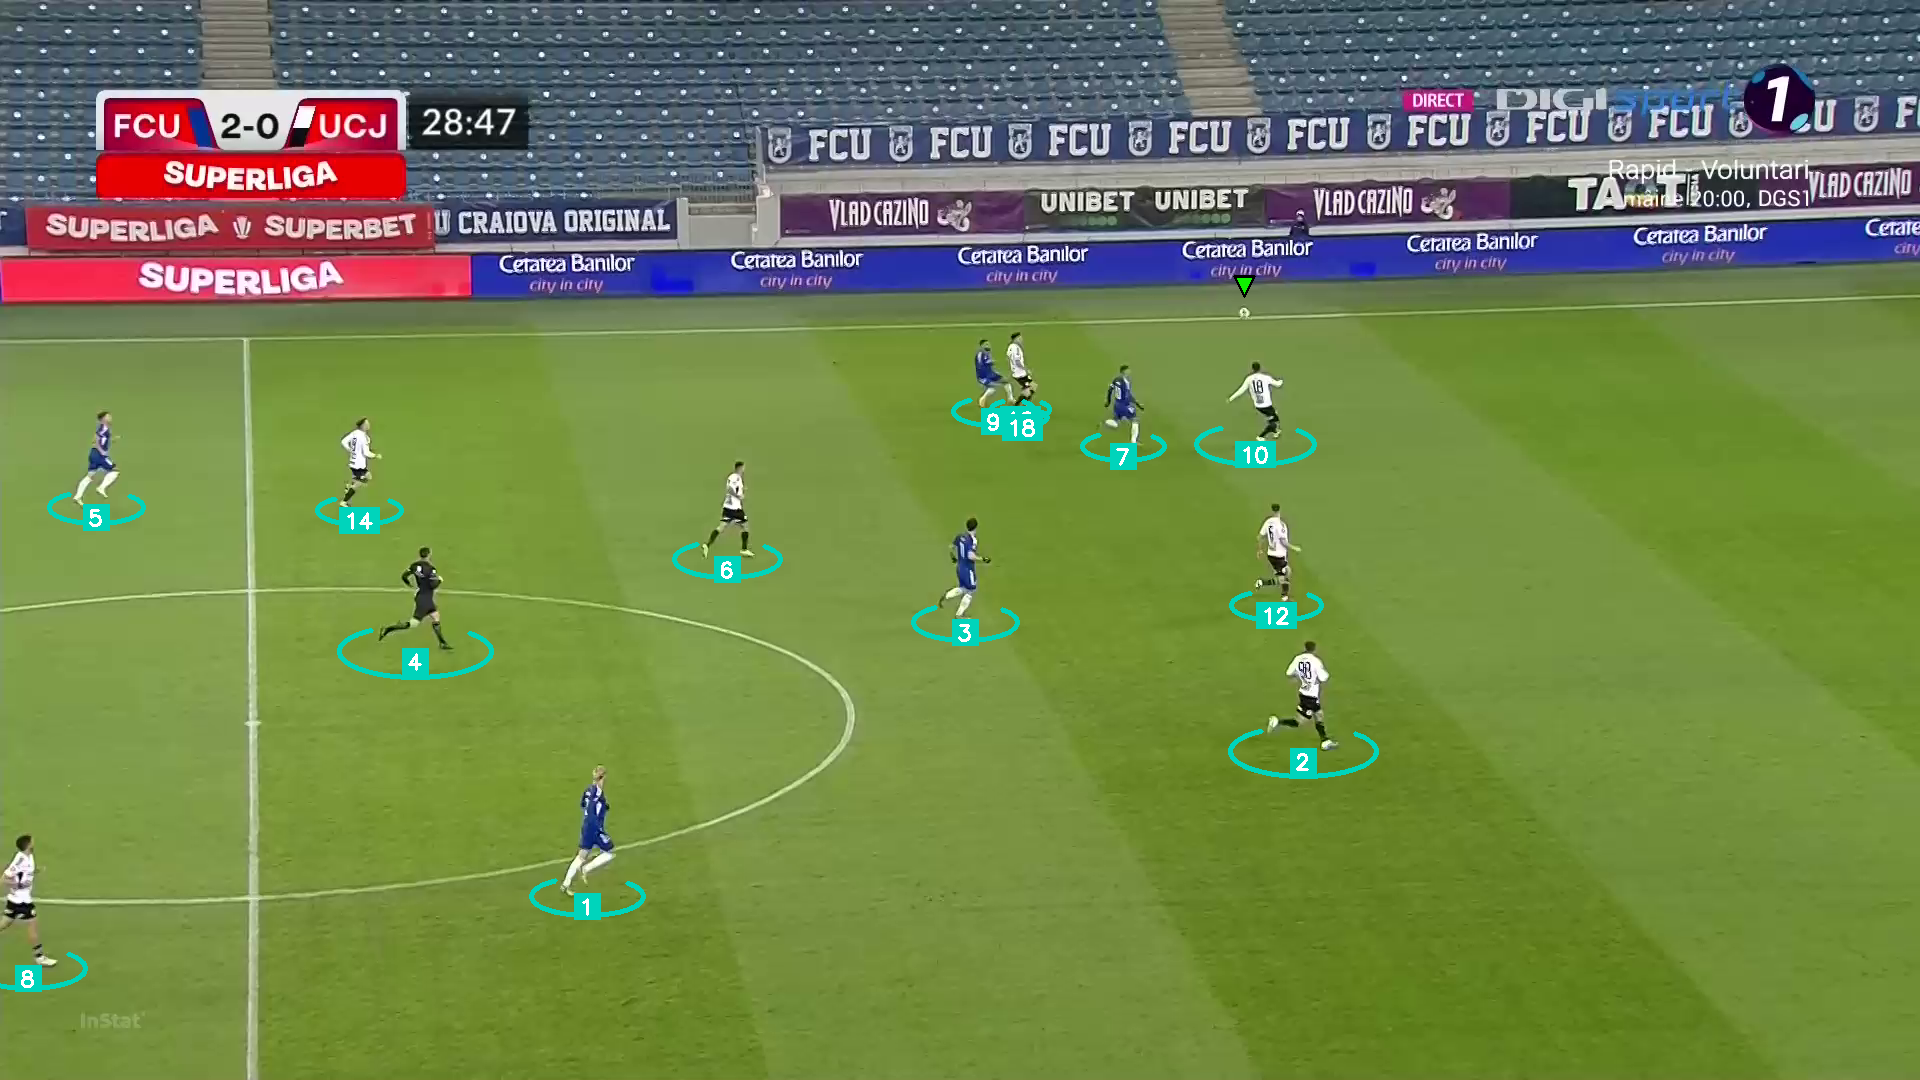

In [ ]:
process(SOURCE_VIDEO_PATH)

In [ ]:
!pip install flask-ngrok

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, request
from werkzeug.utils import secure_filename
import os

app = Flask(__name__)

run_with_ngrok(app)
app.config['UPLOAD_FOLDER'] = 'uploads/'
app.config['OUTPUT_FOLDER'] = 'outputs/'
app.config['ALLOWED_EXTENSIONS'] = {'mp4', 'avi', 'mov'}  # Set allowed video file extensions

# Function to check if the file extension is allowed
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']

# Route for the home page
@app.route('/')
def home():
    return render_template('index.html')

# Route to handle the video upload and model processing
@app.route('/upload', methods=['POST'])
def upload():
    # Check if a file was uploaded
    if 'video' not in request.files:
        return 'No file uploaded', 400

    video = request.files['video']

    # Check if a file with a valid extension was uploaded
    if video.filename == '' or not allowed_file(video.filename):
        return 'Invalid file', 400

    # Save the uploaded video
    filename = secure_filename(video.filename)
    video_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
    video.save(video_path)

    # Process the video with your model (replace this with your model code)
    output_path = process(video_path)  # Call your model function here

    # Move the output file to the output folder
    output_filename = secure_filename(f"output_{filename}")
    output_path_final = os.path.join(app.config['OUTPUT_FOLDER'], output_filename)
    os.rename(output_path, output_path_final)

    # Return the rendered template with the output video path
    return render_template('output.html', output_path=output_filename)

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
